In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# !pip install bokeh

In [25]:
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.models import BoxAnnotation, Label, Legend, Span
from bokeh.palettes import brewer
from bokeh.plotting import figure, show

output_notebook()

Loading BokehJS ...

In [5]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

### Data

In [7]:
data_monthly = pd.read_csv(pm.get_data("monthly_in_situ_co2_mlo.csv"), header=56)

# - replace -99.99 with NaN
data_monthly.replace(to_replace=-99.99, value=np.nan, inplace=True)

# fix column names
cols = [
    "year",
    "month",
    "--",
    "--",
    "CO2",
    "seasonaly_adjusted",
    "fit",
    "seasonally_adjusted_fit",
    "CO2_filled",
    "seasonally_adjusted_filled",
]
data_monthly.columns = cols
cols.remove("--")
cols.remove("--")
data_monthly = data_monthly[cols]


In [9]:
data_monthly.shape

(720, 8)

In [10]:
data_monthly.head()

,year,month,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled
0,1958,1,NaN,NaN,NaN,NaN,NaN,NaN
1,1958,2,NaN,NaN,NaN,NaN,NaN,NaN
2,1958,3,315.69,314.43,316.18,314.90,315.69,314.43
3,1958,4,317.46,315.15,317.30,314.98,317.46,315.15
4,1958,5,317.50,314.73,317.84,315.06,317.50,314.73


In [11]:
# drop rows with nan
data_monthly.dropna(inplace=True)

# fix time index
data_monthly["day"] = 15
data_monthly.index = pd.to_datetime(data_monthly[["year", "month", "day"]])
cols.remove("year")
cols.remove("month")
data_monthly = data_monthly[cols]

data_monthly.head(5)

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled
1958-03-15,315.69,314.43,316.18,314.90,315.69,314.43
1958-04-15,317.46,315.15,317.30,314.98,317.46,315.15
1958-05-15,317.50,314.73,317.84,315.06,317.50,314.73
1958-07-15,315.86,315.17,315.87,315.22,315.86,315.17
1958-08-15,314.93,316.17,314.01,315.29,314.93,316.17


In [14]:
data_monthly.index.min(), data_monthly.index.max()

(Timestamp('1958-03-15 00:00:00'), Timestamp('2017-06-15 00:00:00'))

In [15]:
# function to convert datetimes to numbers that are useful to algorithms
#   this will be useful later when doing prediction


def dates_to_idx(timelist):
    reference_time = pd.to_datetime("1958-03-15")
    t = (timelist - reference_time) / pd.Timedelta(365, "D")
    return np.asarray(t)


t = dates_to_idx(data_monthly.index)

In [ ]:


# normalize CO2 levels
y = data_monthly["CO2"].values
first_co2 = y[0]
std_co2 = np.std(y)
y_n = (y - first_co2) / std_co2

data_monthly = data_monthly.assign(t=t)
data_monthly = data_monthly.assign(y_n=y_n)

In [18]:
# normalize CO2 levels
y = data_monthly["CO2"].values
first_co2 = y[0]
std_co2 = np.std(y)
y_n = (y - first_co2) / std_co2

data_monthly = data_monthly.assign(t=t)
data_monthly = data_monthly.assign(y_n=y_n)

In [19]:
data_monthly.head()

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled,t,y_n
1958-03-15,315.69,314.43,316.18,314.90,315.69,314.43,0.000000,0.000000
1958-04-15,317.46,315.15,317.30,314.98,317.46,315.15,0.084932,0.066821
1958-05-15,317.50,314.73,317.84,315.06,317.50,314.73,0.167123,0.068331
1958-07-15,315.86,315.17,315.87,315.22,315.86,315.17,0.334247,0.006418
1958-08-15,314.93,316.17,314.01,315.29,314.93,316.17,0.419178,-0.028691


##### Use the stretch of data from before 2004 as the "training" set. The data from 2004 to current we'll use to test our predictions.

In [20]:
# split into training and test set
sep_idx = data_monthly.index.searchsorted(pd.to_datetime("2003-12-15"))
data_early = data_monthly.iloc[: sep_idx + 1, :]
data_later = data_monthly.iloc[sep_idx:, :]

In [22]:
data_early.tail()

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled,t,y_n
2003-08-15,374.48,375.94,374.43,375.92,374.48,375.94,45.449315,2.219432
2003-09-15,372.98,376.32,372.74,376.10,372.98,376.32,45.534247,2.162804
2003-10-15,373.00,376.47,372.81,376.27,373.00,376.47,45.616438,2.163559
2003-11-15,374.35,376.53,374.26,376.43,374.35,376.53,45.701370,2.214524
2003-12-15,375.69,376.59,375.69,376.57,375.69,376.59,45.783562,2.265111


In [23]:
# make plot

p = figure(
    x_axis_type="datetime",
    title="Monthly CO2 Readings from Mauna Loa",
    plot_width=550,
    plot_height=350,
)
p.yaxis.axis_label = "CO2 [ppm]"
p.xaxis.axis_label = "Date"
predict_region = BoxAnnotation(
    left=pd.to_datetime("2003-12-15"), fill_alpha=0.1, fill_color="firebrick"
)
p.add_layout(predict_region)
ppm400 = Span(location=400, dimension="width", line_color="red", line_dash="dashed", line_width=2)
p.add_layout(ppm400)

p.line(data_monthly.index, data_monthly["CO2"], line_width=2, line_color="black", alpha=0.5)
p.circle(data_monthly.index, data_monthly["CO2"], line_color="black", alpha=0.1, size=2)

train_label = Label(
    x=100,
    y=165,
    x_units="screen",
    y_units="screen",
    text="Training Set",
    render_mode="css",
    border_line_alpha=0.0,
    background_fill_alpha=0.0,
)
test_label = Label(
    x=585,
    y=80,
    x_units="screen",
    y_units="screen",
    text="Test Set",
    render_mode="css",
    border_line_alpha=0.0,
    background_fill_alpha=0.0,
)

p.add_layout(train_label)
p.add_layout(test_label)
show(p)

In [31]:
data_monthly.head()

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled,t,y_n
1958-03-15,315.69,314.43,316.18,314.90,315.69,314.43,0.000000,0.000000
1958-04-15,317.46,315.15,317.30,314.98,317.46,315.15,0.084932,0.066821
1958-05-15,317.50,314.73,317.84,315.06,317.50,314.73,0.167123,0.068331
1958-07-15,315.86,315.17,315.87,315.22,315.86,315.17,0.334247,0.006418
1958-08-15,314.93,316.17,314.01,315.29,314.93,316.17,0.419178,-0.028691


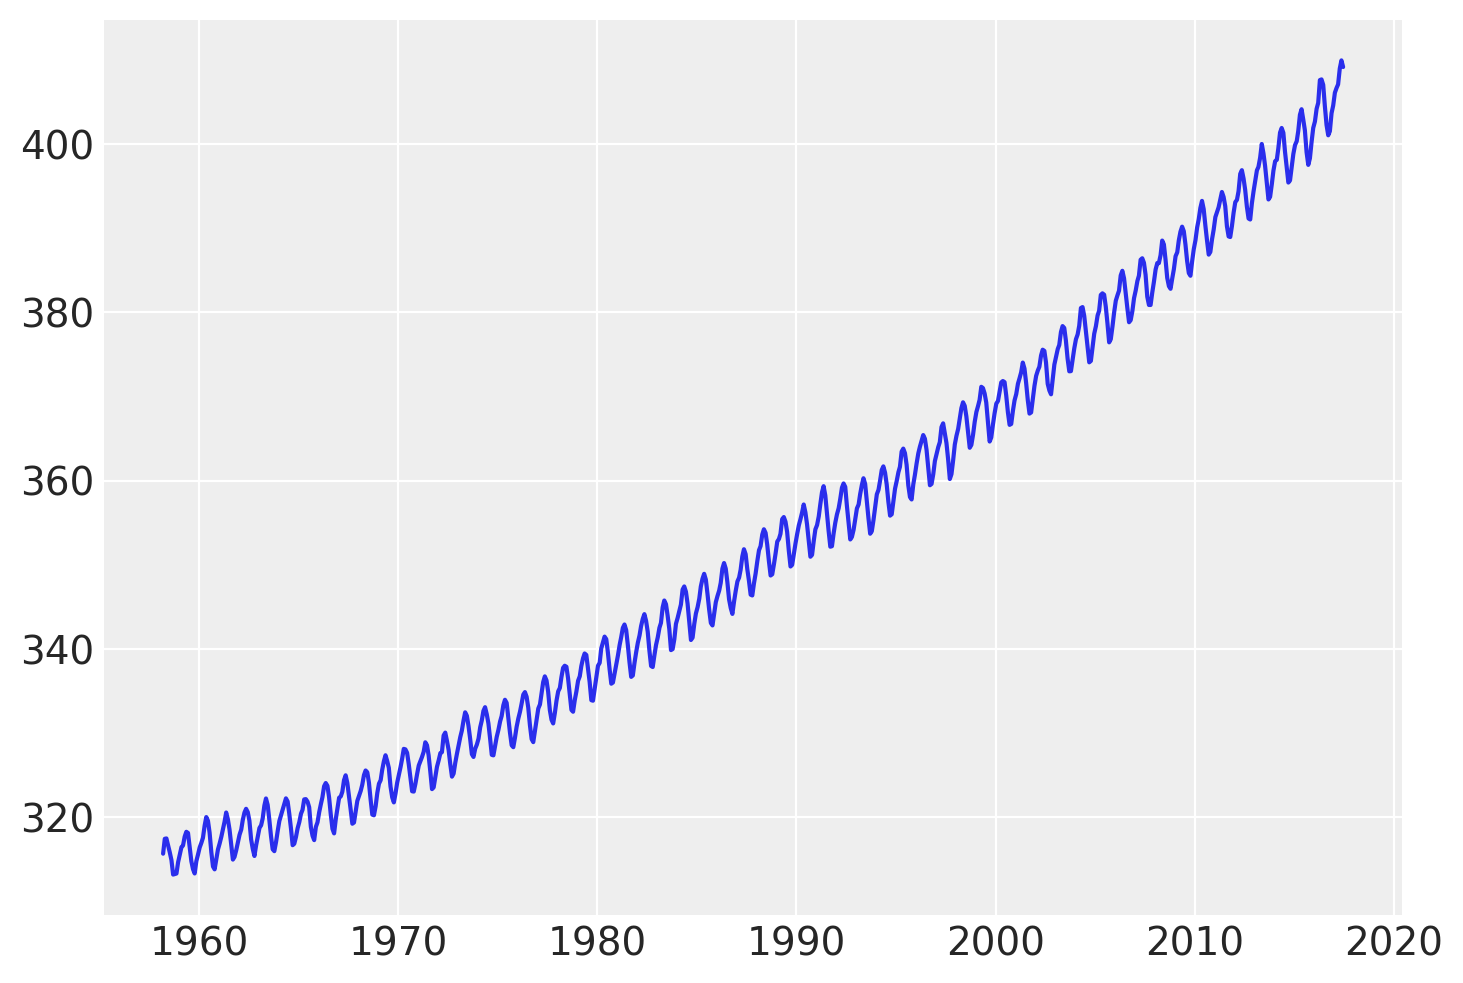

In [30]:
plt.plot(data_monthly.index, data_monthly["CO2"]);

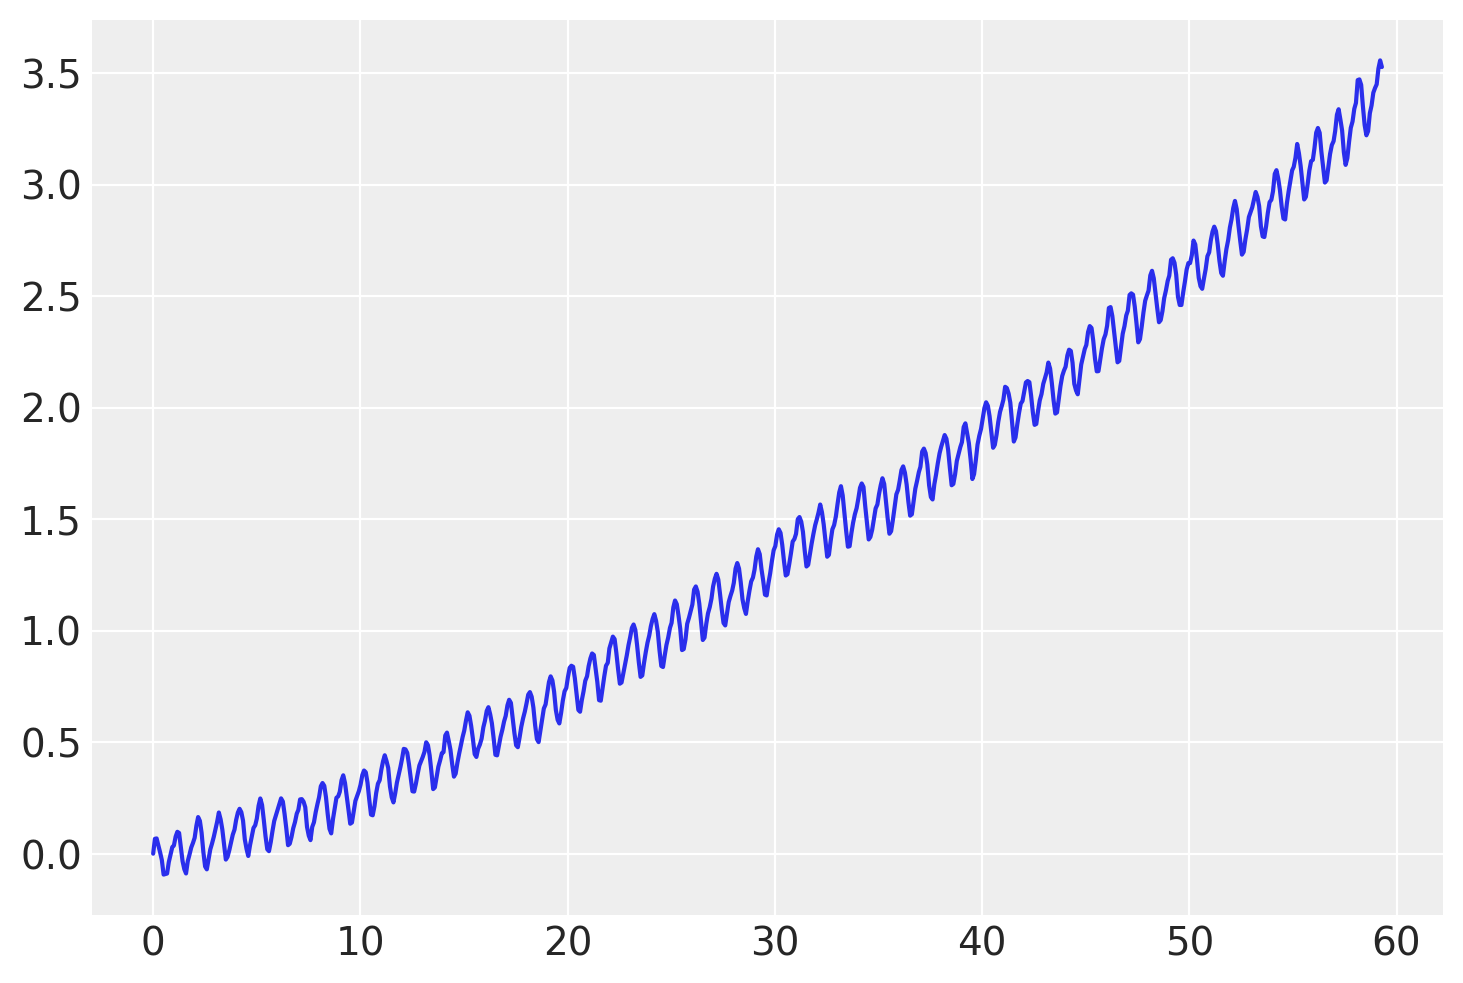

In [32]:
plt.plot(data_monthly.t, data_monthly["y_n"]);

### Modeling the Keeling Curve using GPs

In [34]:
X, y = data_monthly.index, data_monthly.CO2
X.shape, y.shape                    

((707,), (707,))

In [36]:
with pm.Model() as model1:
    l = pm.Exponential('l', 1)
    n = pm.Exponential('n', 1)
    K = n**2 * pm.gp.cov.ExpQuad(1, p)
    
    gp = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    
    obs = gp.marginal_likelihood("obs", X=X.reshape(-1,1), y=y)


You can find the C code in this temporary file: /tmp/theano_compilation_error_63_xsauk


Exception: ("Compilation failed (return status=1): /usr/bin/ld: /home/danph/.pyenv/versions/3.8.5/lib/libpython3.8.a(_warnings.o): relocation R_X86_64_PC32 against symbol `_PyRuntime' can not be used when making a shared object; recompile with -fPIC. /usr/bin/ld: final link failed: Bad value. collect2: error: ld returned 1 exit status. ", 'FunctionGraph(Elemwise{true_div,no_inplace}(TensorConstant{1.0}, TensorConstant{1.0}))')